In [44]:
# Make better use of Jupyter Notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [103]:
import numpy as np
import pandas as pd
from collections import Counter

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
%config InlineBackend.figure_formats = ['retina']
sns.set_style("white")


In [134]:
restaurants_clean = pd.read_pickle('./restaurants_clean.pkl')

In [135]:
restaurants_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1285 entries, 3540 to 5289
Data columns (total 5 columns):
Success          1285 non-null int64
Month Opened     1285 non-null int64
Neighborhood     1285 non-null object
Food             1285 non-null object
ZHVI_AllHomes    1285 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 60.2+ KB


**Split data into data/target categories**

In [136]:
X = restaurants_clean[['Month Opened', 'Neighborhood', 'Food', 'ZHVI_AllHomes']]
y = restaurants_clean['Success']

In [137]:
#Transform 'Month Opened' using Ordinal Encoder
ord_enc = OrdinalEncoder()
X['Month Opened'] = ord_enc.fit_transform(X['Month Opened'].values.reshape(-1, 1))


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [138]:
#Transform 'Neighborhood' and 'Food' using get_dummies
X = pd.concat([X, pd.get_dummies(X[['Neighborhood', 'Food']])], axis=1)
X.drop(['Neighborhood', 'Food'], axis=1, inplace=True)

In [139]:
X.head()

,Month Opened,ZHVI_AllHomes,Neighborhood_Bayview-Hunters Point,Neighborhood_Castro/Noe Valley,Neighborhood_Chinatown,Neighborhood_Haight-Ashbury,Neighborhood_Hayes Valley/Tenderloin/North of Market,Neighborhood_Ingelside-Excelsior/Crocker-Amazon,Neighborhood_Inner Mission/Bernal Heights,Neighborhood_Inner Richmond,...,Food_Latin American,Food_Mediterranean,Food_Mexican,Food_Middle Eastern,Food_Other,Food_Pizza,Food_Russian,Food_Seafood,Food_Southeast Asian,Food_Spanish/Portuguese
3540,0.0,852600.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3585,0.0,986600.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3601,1.0,885900.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3615,1.0,1154200.0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3622,1.0,1671600.0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


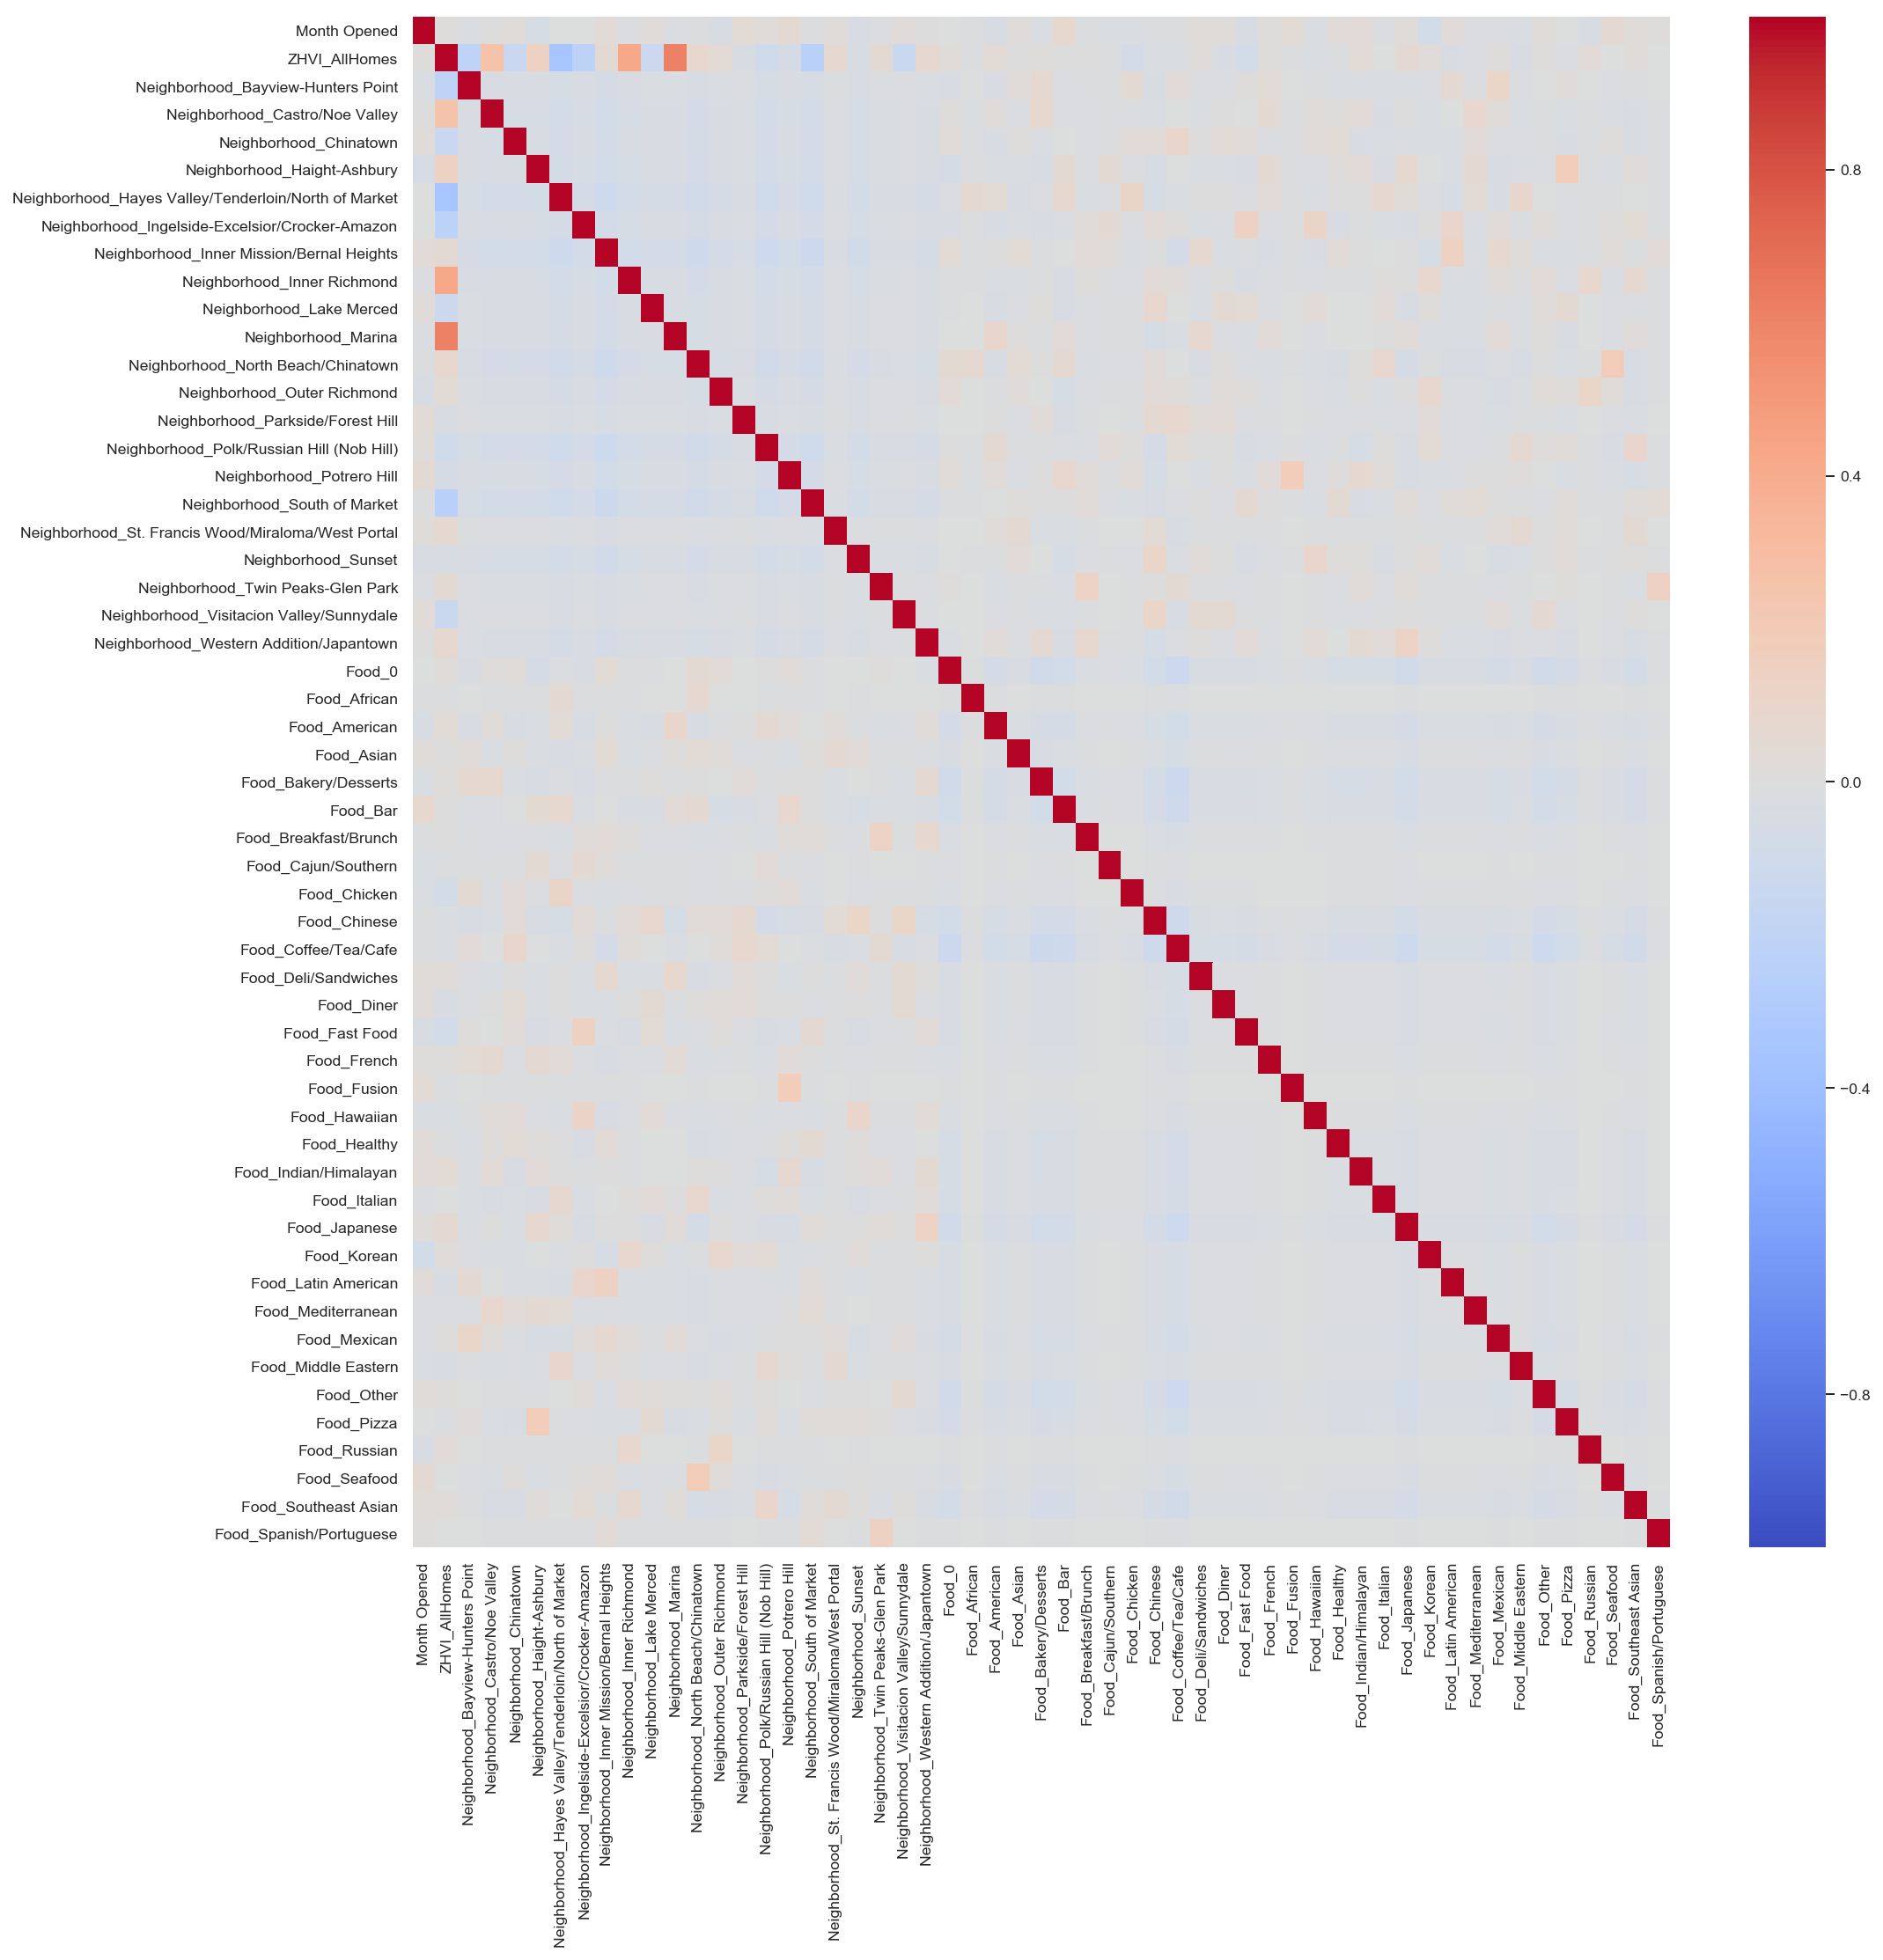

In [142]:
#Not much feature collinearity --> year opened & ZHVI close, since ZHVIs generally increase over time
plt.figure(figsize=(16, 16))
sns.set_context("paper")
sns.heatmap(X.corr(), annot=False, cmap='coolwarm', vmin=-1, vmax=1);

### Modeling

### Train/Test Split

In [141]:
# As usual, create our train/test split
# This will become particularly important as we calculate our error metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
#Restaurant saturation/aggregation

### Standardize ZHVI_AllHomes

In [151]:
#After train/test split, Standardize
from sklearn.preprocessing import StandardScaler

scaled_train = X_train.copy()
scaled_test = X_test.copy()

col_name = ['ZHVI_AllHomes']
features_train = scaled_train[col_name]
features_test = scaled_test[col_name]


scaler = StandardScaler()
train_ZHVI = scaler.fit_transform(features_train)
test_ZHVI = scaler.transform(features_test)

In [154]:
X_train['ZHVI_AllHomes'] = train_ZHVI
X_test['ZHVI_AllHomes'] = test_ZHVI

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [155]:
X_train.head()

,Month Opened,ZHVI_AllHomes,Neighborhood_Bayview-Hunters Point,Neighborhood_Castro/Noe Valley,Neighborhood_Chinatown,Neighborhood_Haight-Ashbury,Neighborhood_Hayes Valley/Tenderloin/North of Market,Neighborhood_Ingelside-Excelsior/Crocker-Amazon,Neighborhood_Inner Mission/Bernal Heights,Neighborhood_Inner Richmond,...,Food_Latin American,Food_Mediterranean,Food_Mexican,Food_Middle Eastern,Food_Other,Food_Pizza,Food_Russian,Food_Seafood,Food_Southeast Asian,Food_Spanish/Portuguese
5029,2.0,-0.675885,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7781,2.0,-0.167575,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4817,9.0,0.156286,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3982,8.0,0.486580,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4194,0.0,0.417335,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Upsampling

In [88]:
#Probably don't need to upsample

print(f'Class 0: {restaurants_clean.Success.value_counts()[0]}')
print(f'Class 1: {restaurants_clean.Success.value_counts()[1]}')
print(f'Proportion: {round(restaurants_clean.Success.value_counts()[0] / restaurants_clean.Success.value_counts()[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(restaurants_clean.Success.value_counts()[0] / sum(restaurants_clean.Success.value_counts()), 4)*100}')

Class 0: 350
Class 1: 935
Proportion: 0.37 : 1
Percentage of Majority Class: 27.24


In [25]:
#Counter(y_train)

In [38]:
# Import ADASYN and create a new oversampled dataset
#from imblearn.over_sampling import ADASYN

#X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X_train, y_train)

In [26]:
# Check that our dataset is reasonably balanced

#Counter(y_adasyn)

#### Function to create Confusion Matrices

In [168]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    success_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(success_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=[0, 1],
           yticklabels=[0, 1]);
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix');

### KNN Model

In [169]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("Scores for kNN")
print("Training: {:6.2f}%".format(100*knn.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_test, y_test)))
f1_score(knn.predict(X_test), y_test)

Scores for kNN
Training:  80.65%
Test set:  64.51%


0.7689713322091061

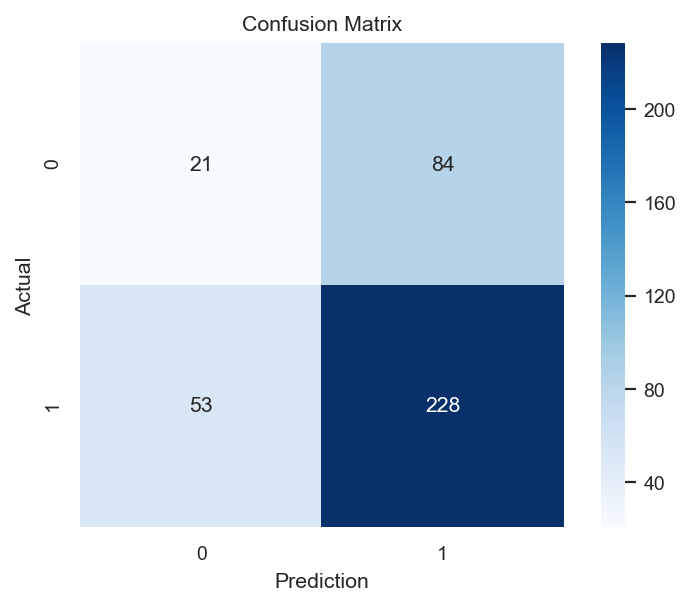

In [170]:
make_confusion_matrix(knn)

#### KNN with ADASYN

In [171]:
#knn1 = KNeighborsClassifier(n_neighbors=9)
#knn1.fit(X_adasyn, y_adasyn)
#print("Scores for kNN")
#print("Training: {:6.2f}%".format(100*knn1.score(X_adasyn, y_adasyn)))
#print("Test set: {:6.2f}%".format(100*knn1.score(X_adasyn, y_adasyn)))
#f1_score(knn1.predict(X_test), y_test)

In [172]:
#make_confusion_matrix(knn1)

### Logistic Regression Model

In [173]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
print("Scores for Logistic Regression")
print("Training: {:6.2f}%".format(100*lr.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*lr.score(X_test, y_test)))
f1_score(lr.predict(X_test), y_test)

Scores for Logistic Regression
Training:  73.30%
Test set:  72.28%


0.837138508371385

In [174]:
#F1 score close to 1 means model is close to balanced between Precision & Recall

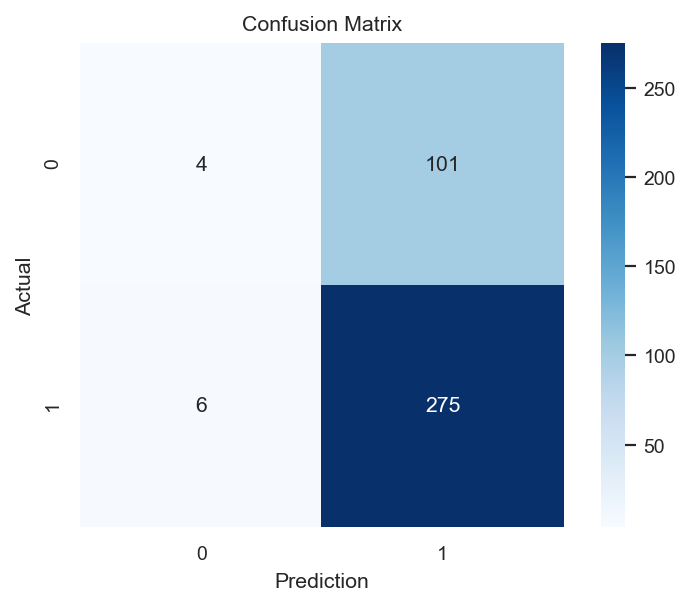

In [175]:
make_confusion_matrix(lr)

#### Logistic Regression with ADASYN

In [176]:
#lr1 = LogisticRegression(solver='lbfgs')
#lr1.fit(X_adasyn, y_adasyn)
#print("Scores for Logistic Regression")
#print("Training: {:6.2f}%".format(100*lr1.score(X_adasyn, y_adasyn)))
#print("Test set: {:6.2f}%".format(100*lr1.score(X_adasyn, y_adasyn)))
#f1_score(lr1.predict(X_test), y_test)


In [177]:
#make_confusion_matrix(lr1)

### Naive Bayes

In [178]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
print("Scores for Naive Bayes")
print("Training: {:6.2f}%".format(100*nb.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*nb.score(X_test, y_test)))
f1_score(nb.predict(X_test), y_test)

Scores for Naive Bayes
Training:  35.48%
Test set:  32.12%


0.19135802469135804

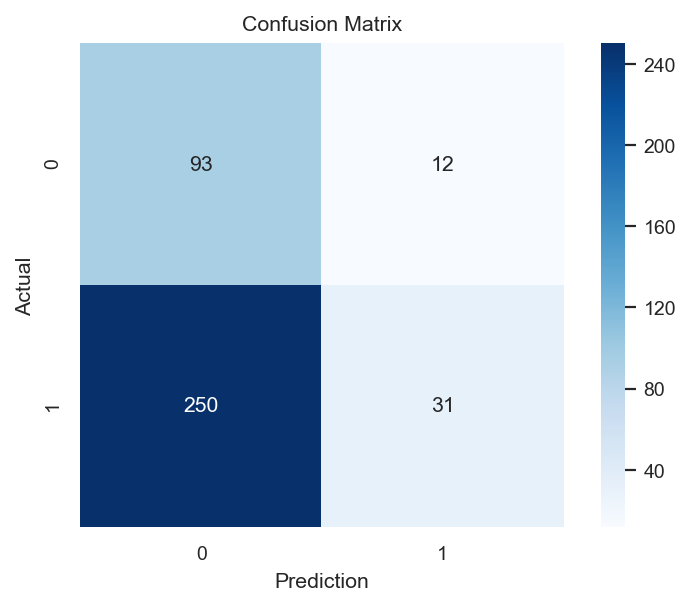

In [179]:
make_confusion_matrix(nb)

In [180]:
#nb1 = GaussianNB()
#nb1.fit(X_adasyn, y_adasyn)
#print("Scores for Naive Bayes")
#print("Training: {:6.2f}%".format(100*nb1.score(X_adasyn, y_adasyn)))
#print("Test set: {:6.2f}%".format(100*nb1.score(X_adasyn, y_adasyn)))
#f1_score(nb1.predict(X_test), y_test)

In [181]:
#make_confusion_matrix(nb1)

### Linear SVM

In [182]:
from sklearn.svm import LinearSVC

lin_svc = LinearSVC()
lin_svc.fit(X_train, y_train)
print("Scores for Linear SVM")
print("Training: {:6.2f}%".format(100*lin_svc.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*lin_svc.score(X_test, y_test)))
f1_score(lin_svc.predict(X_test), y_test)

Scores for Linear SVM
Training:  75.42%
Test set:  71.76%


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.8320493066255779

### RBF SVM

In [183]:
from sklearn.svm import SVC

rbf_svc = SVC(kernel="rbf", gamma="auto",probability=True)
rbf_svc.fit(X_train, y_train)
print("Scores for RBF SVM")
print("Training: {:6.2f}%".format(100*rbf_svc.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*rbf_svc.score(X_test, y_test)))
f1_score(rbf_svc.predict(X_test), y_test)

Scores for RBF SVM
Training:  72.75%
Test set:  72.80%


0.8425787106446777

In [184]:
# Create the parameter grid based on the results of random search 

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 
              'gamma' : [0.001, 0.01, 0.1, 1]}


grid_search_svc = GridSearchCV(estimator = rbf_svc, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)


In [185]:
# Fit the grid search to the data
grid_search_svc.fit(X_train, y_train)
grid_search_svc.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.9s finished


{'C': 0.001, 'gamma': 0.001}

In [131]:
best_svc = grid_search_svc.best_estimator_

### Poly SVM

In [186]:
#from sklearn.svm import SVC

#poly_svc = SVC(kernel="poly", gamma="auto")
#poly_svc.fit(X_train, y_train)
#print("Scores for Poly SVM")
#print("Training: {:6.2f}%".format(100*poly_svc.score(X_train, y_train)))
#print("Test set: {:6.2f}%".format(100*poly_svc.score(X_test, y_test)))
#f1_score(poly_svc.predict(X_test), y_test)

### Random Forest

In [187]:
from sklearn.ensemble import RandomForestClassifier

rForest = RandomForestClassifier(n_estimators=100)
rForest.fit(X_train, y_train)
print("Scores for Random Forest")
print("Training: {:6.2f}%".format(100*rForest.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*rForest.score(X_test, y_test)))
f1_score(rForest.predict(X_test), y_test)

Scores for Random Forest
Training:  97.66%
Test set:  66.58%


0.7831932773109243

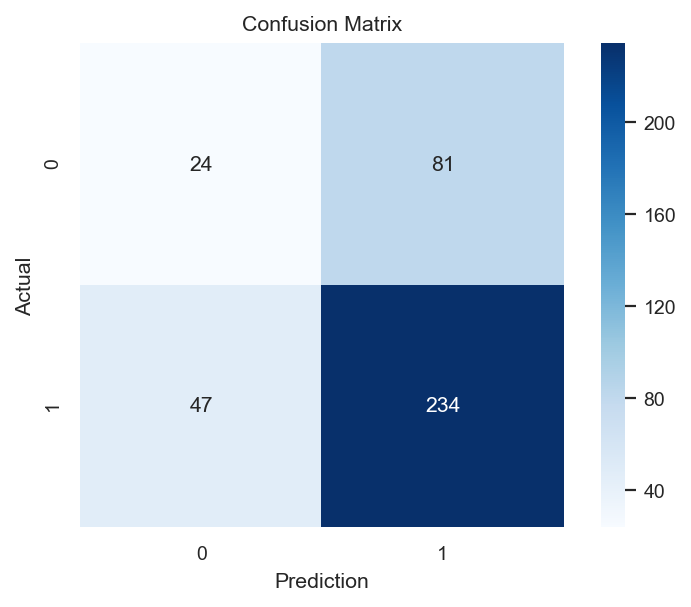

In [188]:
make_confusion_matrix(rForest)

In [189]:
#GridSearch to Optimize hyperparameters

In [190]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rForest, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)


In [191]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  4.3min finished


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 100}

In [192]:
best_grid = grid_search.best_estimator_

In [201]:
f1_score(best_grid.predict(X_test), y_test)

0.8425787106446777

### ROC Curve

In [194]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
from sklearn.metrics import roc_auc_score, roc_curve

# predict probabilities, keep probabilities for the positive outcome only

#KNN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, knn.predict_proba(X_test)[:, 1])
print("KNN ROC AUC score = ", roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1]))

#Logistic Regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])
print("LR ROC AUC score = ", roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1]))

#Naive Bayes
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, nb.predict_proba(X_test)[:, 1])
print("Naive Bayes ROC AUC score = ", roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1]))

#Linear SVM
#fpr_lin_svc, tpr_lin_svc, thresholds_lin_svc = roc_curve(y_test, lin_svc.predict_proba(X_test)[:, 1])
#print("Linear SVM ROC AUC score = ", roc_auc_score(y_test, lin_svc.predict_proba(X_test)[:, 1]))

#RBF SVM
fpr_rbf_svc, tpr_rbf_svc, thresholds_rbf_svc = roc_curve(y_test, rbf_svc.predict_proba(X_test)[:, 1])
print("RBF SVM ROC AUC score = ", roc_auc_score(y_test, rbf_svc.predict_proba(X_test)[:, 1]))

#GridSearch RBF SVM

#fpr_best_svc, tpr_best_svc, thresholds_best_svc = roc_curve(y_test, best_svc.predict_proba(X_test)[:, 1])
#print("GridSearch RBF SVM ROC AUC score = ", roc_auc_score(y_test, best_svc.predict_proba(X_test)[:, 1]))

#Poly SVM
#fpr_poly_svc, tpr_poly_svc, thresholds_poly_svc = roc_curve(y_test, poly_svc.predict_proba(X_test)[:, 1])
#print("Poly SVM ROC AUC score = ", roc_auc_score(y_test, poly_svc.predict_proba(X_test)[:, 1]))

#Random Forest
fpr_rForest, tpr_rForest, thresholds_rForest = roc_curve(y_test, rForest.predict_proba(X_test)[:, 1])
print("Random Forest ROC AUC score = ", roc_auc_score(y_test, rForest.predict_proba(X_test)[:, 1]))

#GridSearch RF
fpr_best_grid, tpr_best_grid, thresholds_best_grid = roc_curve(y_test, best_grid.predict_proba(X_test)[:, 1])
print("GridSearch Random Forest ROC AUC score = ", roc_auc_score(y_test, best_grid.predict_proba(X_test)[:, 1]))



KNN ROC AUC score =  0.5341128622267413
LR ROC AUC score =  0.5941874258600237
Naive Bayes ROC AUC score =  0.5305033045246569
RBF SVM ROC AUC score =  0.5446365022877478
Random Forest ROC AUC score =  0.5835790543975597
GridSearch Random Forest ROC AUC score =  0.5984070496526013


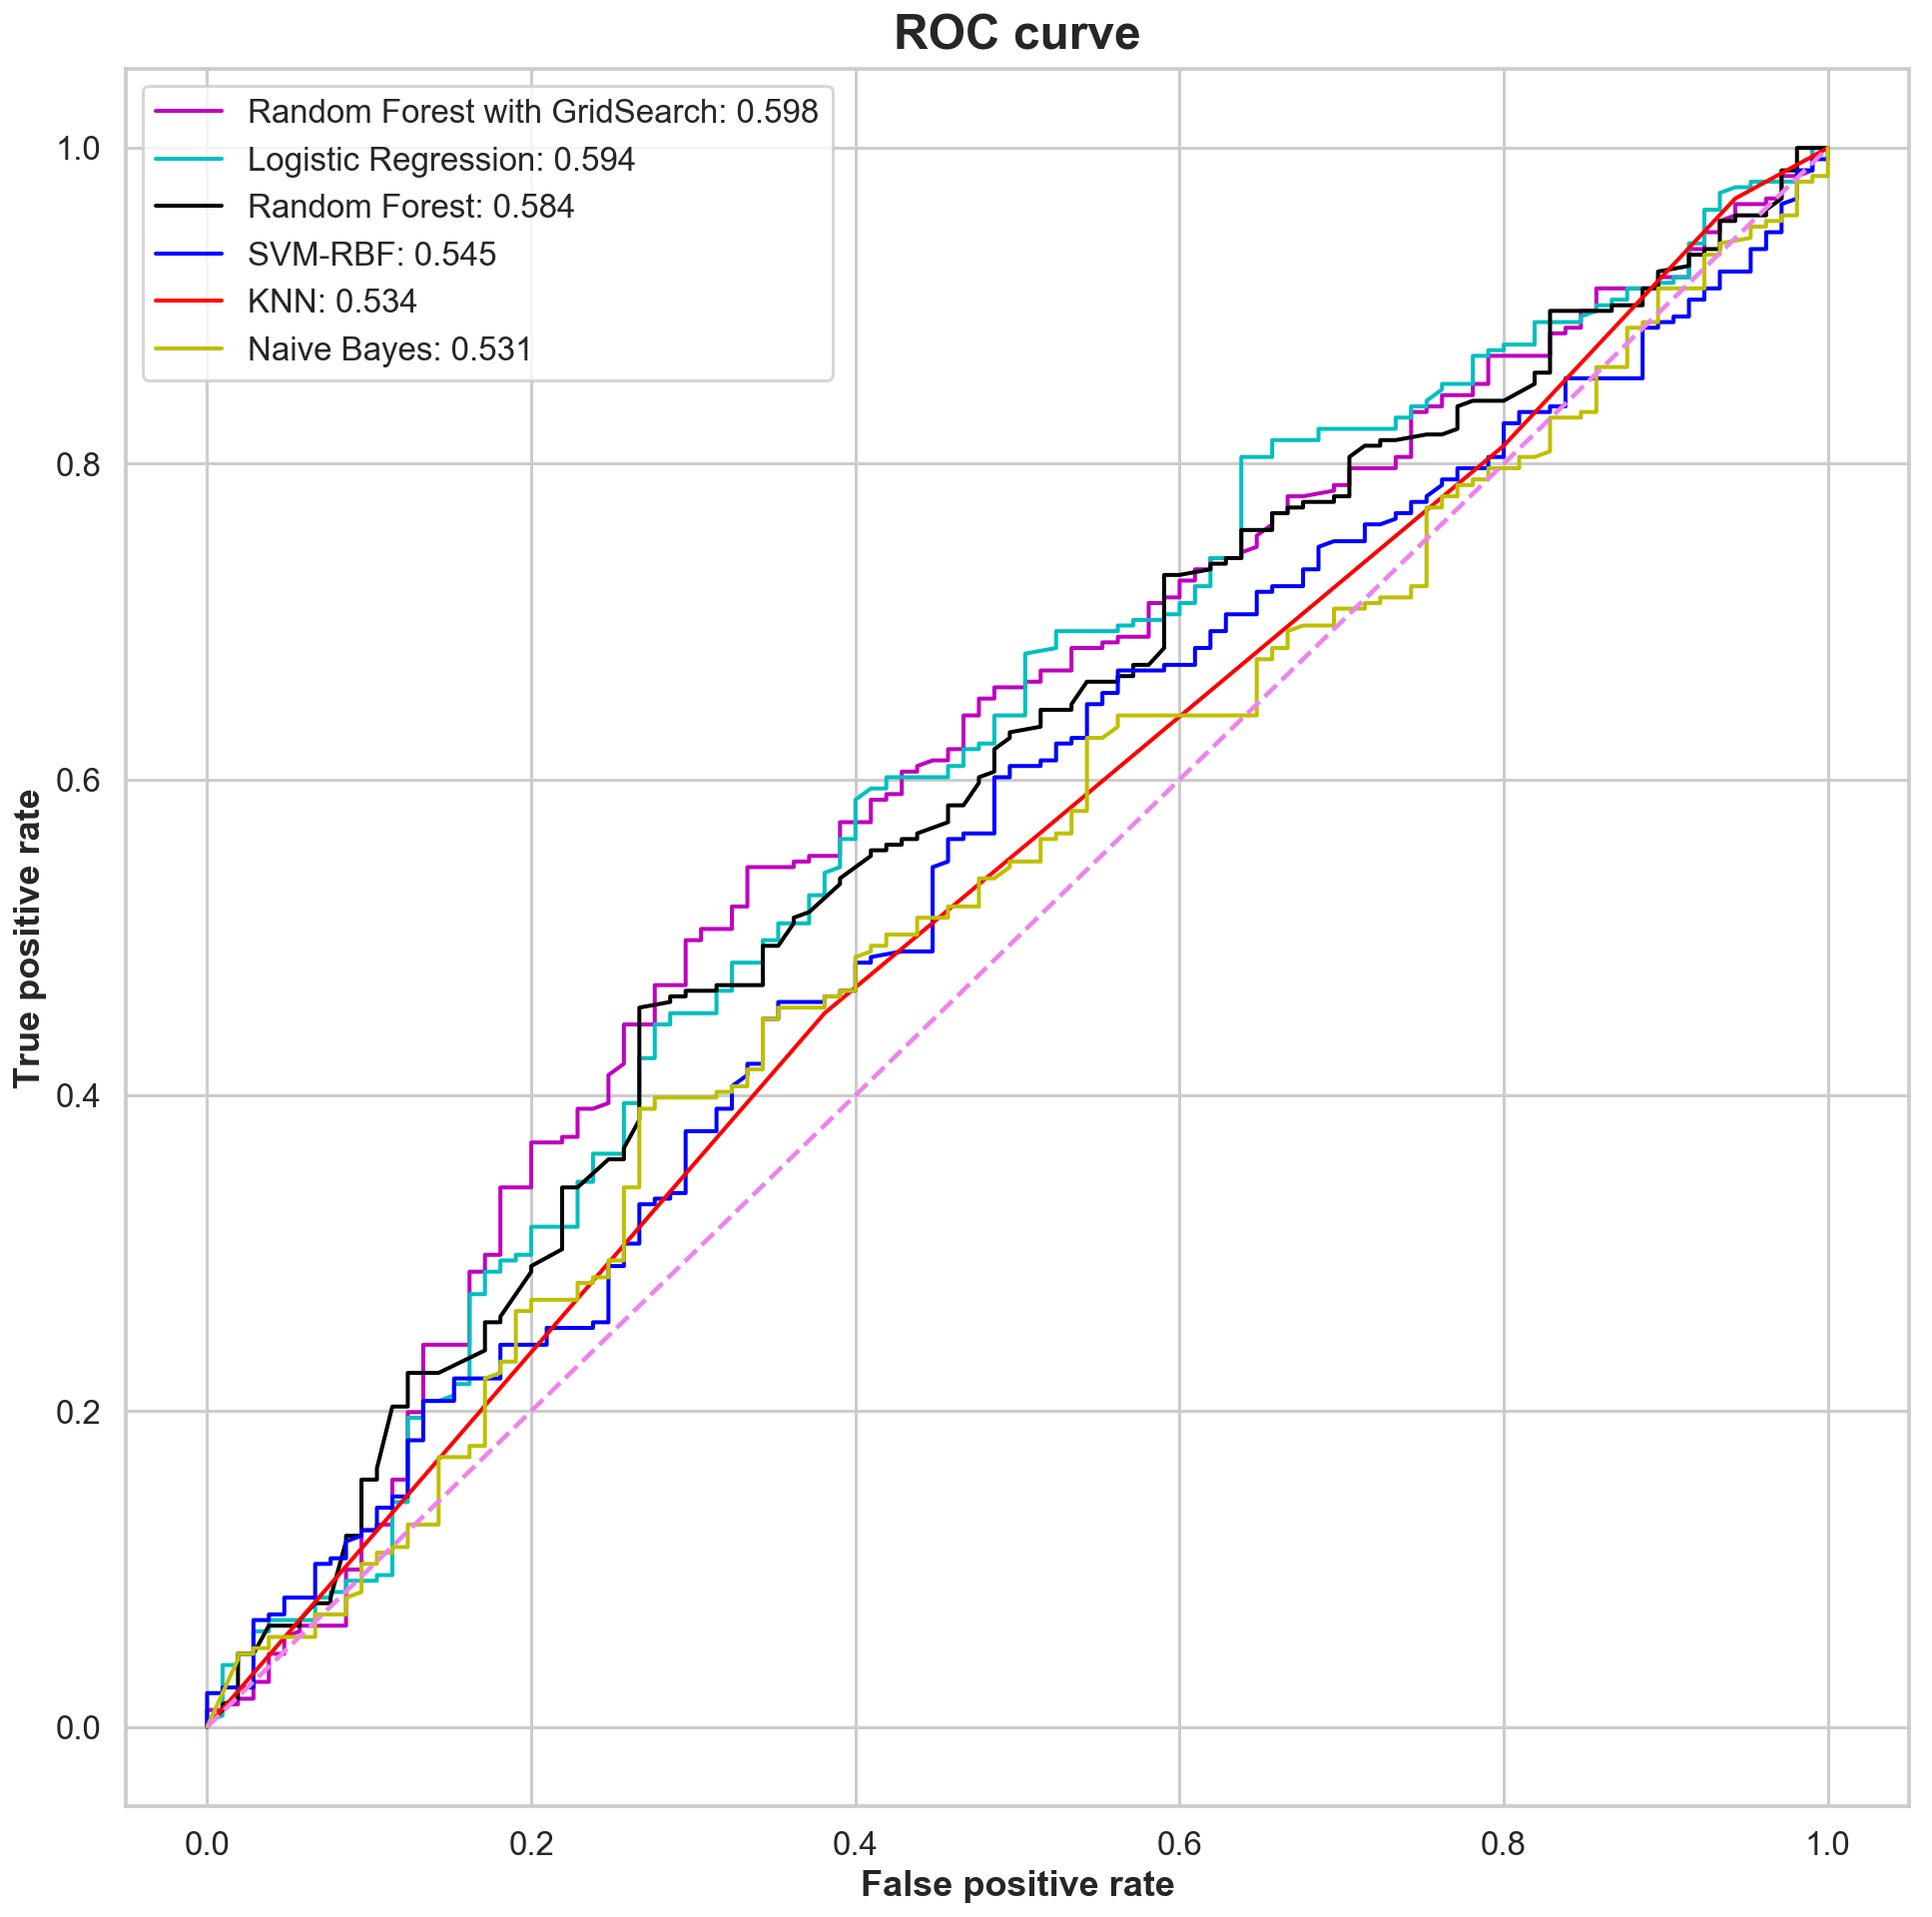

In [200]:
#Make a histogram for closed restaurants to see the distribution across number of years open
plt.figure(figsize=(16, 16))

# Classification and ROC analysis
#GridSearch random forest
plt.plot(fpr_best_grid, tpr_best_grid, c='m', lw=2)

#logistic
plt.plot(fpr_lr, tpr_lr, c='c', lw=2)

#random forest
plt.plot(fpr_rForest, tpr_rForest, c='k', lw=2)

#rbf svm
plt.plot(fpr_rbf_svc, tpr_rbf_svc, c='b', lw=2)


#knn
plt.plot(fpr_knn, tpr_knn, c='r', lw=2)

#naive bayes
plt.plot(fpr_nb, tpr_nb, c='y', lw=2)





# plot no-skill line
plt.plot([0,1],[0,1],c='violet',ls='--')

plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate', fontdict={'fontweight': 'bold', 'fontsize': 18})
plt.ylabel('True positive rate', fontdict={'fontweight': 'bold', 'fontsize': 18})
plt.title('ROC curve', fontdict={'fontweight': 'bold', 'fontsize': 24}, 
          pad = 10)

plt.legend(labels=['Random Forest with GridSearch: 0.598',
                   'Logistic Regression: 0.594', 
                   'Random Forest: 0.584', 
                   'SVM-RBF: 0.545', 
                   'KNN: 0.534', 
                   'Naive Bayes: 0.531'])
sns.set_style('whitegrid')
sns.set_context('talk')
plt.savefig('ROC_init.png', bbox_inches = 'tight');




We'll definitely want to account for the imbalance later (though not in this notebook) when we try to optimize our F1 score, the chosen metric for scoring our model.

In [ ]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lm.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

In [ ]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

#### Log-Loss Cross-Entropy

>- Log-loss allows us to measure not just "did our model get XYZ right?" but "how confident was it in when predicting?"
>
>- A lower log-loss is better


In [ ]:
from sklearn.metrics import log_loss

print("Log-loss on logit: {:6.4f}".format(log_loss(y_test, lm.predict_proba(X_test))))

#### Compare models against Dummy Classifier (random guessing)

In [ ]:
from sklearn.dummy import DummyClassifier

dc = DummyClassifier()
dc.fit(X_train, y_train)
print("Log-loss on dummy classifier: {:6.4f}".format(log_loss(y_test, dc.predict_proba(X_test))))

In [ ]:
print("Logistic accuracy: {:6.4f}".format(lm.score(X_test, y_test)))
print("Dummy accuracy: {:6.4f}".format(dc.score(X_test, y_test)))